In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data = "/content/drive/MyDrive/dataset_tomat/training"
test_data = "/content/drive/MyDrive/dataset_tomat/testing"

In [4]:
images = ['half-mature', 'immature', 'mature','reject']

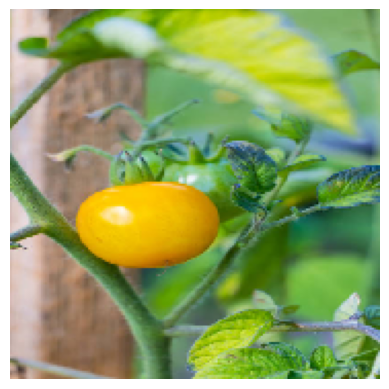

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

img = load_img(test_data + "//half-mature//11.jpg", target_size=(180,180))
plt.imshow(img)
plt.axis("off")
plt.show()

In [6]:
x = img_to_array(img)
print(x.shape)

(180, 180, 3)


In [7]:
className = glob(train_data + '/*')
number_of_class = len(className)
print(number_of_class)

4


In [15]:
# === Augmentasi Data ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    shear_range=0.3,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2
)

# Dataset
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset_tomat/training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset_tomat/training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset_tomat/testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 4801 images belonging to 4 classes.
Found 1199 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [18]:
# === Bangun Model MobileNetV2 ===
from tensorflow.keras import regularizers

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze awal

x = base_model.output
x = Dropout(0.3)(x)  # Extra dropout sebelum pooling
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# === Training awal dengan base_model frozen ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7580 - loss: 2.4045

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.7588 - loss: 2.3998 - val_accuracy: 0.8048 - val_loss: 1.2441 - learning_rate: 0.0010
Epoch 2/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.9403 - loss: 0.8036 - val_accuracy: 0.8524 - val_loss: 0.7413 - learning_rate: 0.0010
Epoch 3/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.9552 - loss: 0.4687 - val_accuracy: 0.8532 - val_loss: 0.6349 - learning_rate: 0.0010
Epoch 4/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.9534 - loss: 0.3606 - val_accuracy: 0.8274 - val_loss: 0.6536 - learning_rate: 0.0010
Epoch 5/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.9610 - loss: 0.2953 - val_accuracy: 0.8741 - val_loss: 0.5078 - learning_rate: 0.0010


In [20]:
# === Fine-Tuning: Buka sebagian layer base_model ===
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Compile ulang dengan learning rate kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Training lanjutan (fine-tune) ===
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]
)

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - accuracy: 0.8156 - loss: 0.7312 - val_accuracy: 0.8332 - val_loss: 0.6076 - learning_rate: 1.0000e-05
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.9420 - loss: 0.3212 - val_accuracy: 0.8349 - val_loss: 0.6392 - learning_rate: 1.0000e-05
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 453s 3s/step - accuracy: 0.9640 - loss: 0.2694 - val_accuracy: 0.8540 - val_loss: 0.5945 - learning_rate: 1.0000e-05
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - accuracy: 0.9680 - loss: 0.2513 - val_accuracy: 0.8532 - val_loss: 0.5645 - learning_rate: 1.0000e-05
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.9739 - loss: 0.2287 - val_accuracy: 0.8616 - val_loss: 0.5502 - learning_rate: 1.0000e-05
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.9703 - loss: 0.2291 - val_accuracy: 0.8732 - val_loss: 0.5301 - learning_rate: 1.0000e-05
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - acc

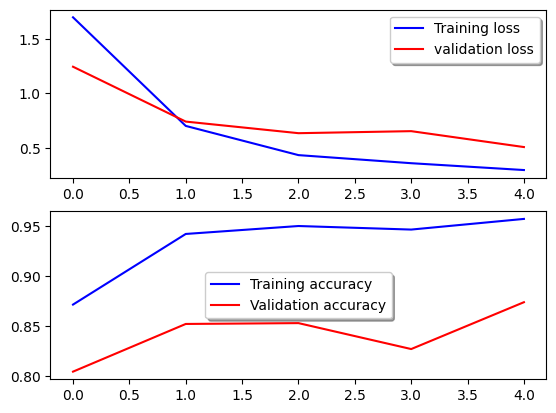

In [21]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss") # Remove axes=ax[0]
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 153s 8s/step


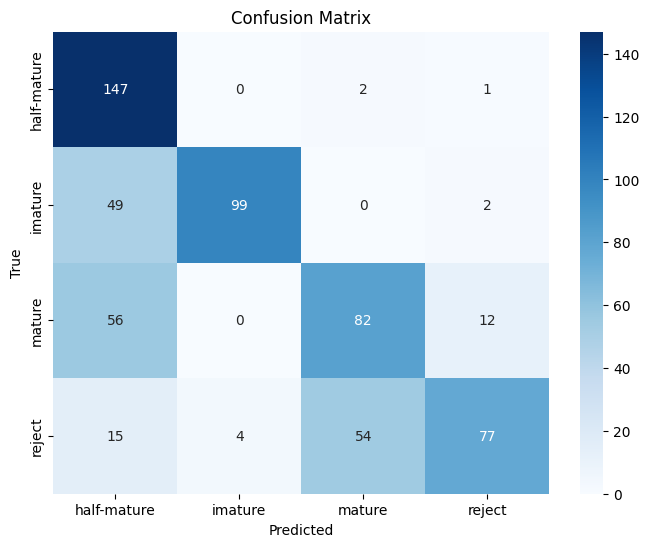


Classification Report:
              precision    recall  f1-score   support

 half-mature       0.55      0.98      0.71       150
     imature       0.96      0.66      0.78       150
      mature       0.59      0.55      0.57       150
      reject       0.84      0.51      0.64       150

    accuracy                           0.68       600
   macro avg       0.74      0.67      0.67       600
weighted avg       0.74      0.68      0.67       600



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model = model)

model_tflite=converter.convert()

open("tomat.tflite", "wb").write(model_tflite)

Saved artifact at '/tmp/tmp7fsz1dw_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_470')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136702912981968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136702911281104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136702911282064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136702912980624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136702912982736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136702911283024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136702911282256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136702909743376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136702911282640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136702911280912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1367029097

9517460

In [24]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="tomat.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])

print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])


Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>
